In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from zipfile import ZipFile
import pandas as pd
import torchdata
import torch

from skimage.io import imread
from PIL import ImageColor, Image
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

/home/mike/6semak/fit_predict/image_segmentation/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
train_color_path = 'main_data/images/train_color.zip'
train_label_path = 'main_data/images/train_label.zip'
dataset_description_path = 'main_data/train_info.csv'
sample_submission_path = 'main_data/sample_submission.csv'

In [3]:
classes_ids_pairs = { 'car': 33,
'motorbicycle': 34,
'bicycle': 35,
'person': 36,
'rider': 37,
'truck': 38,
'bus': 39,
'tricycle': 40,
'others': 0,
'rover': 1,
'sky': 17,
'car_groups': 161,
'motorbicycle_group': 162,
'bicycle_group': 163,
'person_group': 164,
'rider_group': 165,
'truck_group': 166,
'bus_group': 167,
'tricycle_group': 168,
'road': 49,
'siderwalk': 50,
'traffic_cone': 65,
'road_pile': 66,
'fence': 67,
'traffic_light': 81,
'pole': 82,
'traffic_sign': 83,
'wall': 84,
'dustbin': 85,
'billboard': 86,
'building': 97,
'bridge': 98,
'tunnel': 99,
'overpass': 100,
'vegatation': 113,
'unlabeled': 255}

ids_classes_pairs = {classes_ids_pairs[j]: j for j in classes_ids_pairs}
len(ids_classes_pairs)

36

# show of

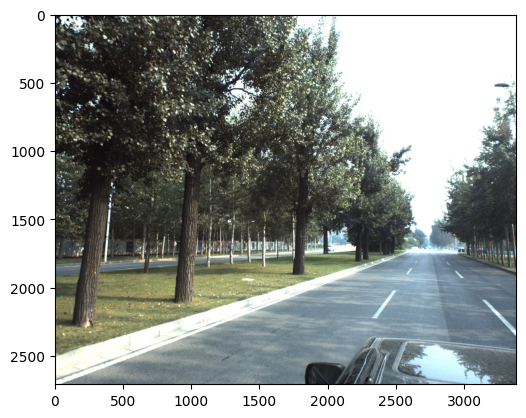

In [4]:
with ZipFile(train_color_path) as myzip:
    with myzip.open('train_color/' + '170908_072637296_Camera_5.jpg') as myfile:
        image = mpimg.imread(myfile)
        plt.imshow(image)
        

In [5]:
image.shape

(2710, 3384, 3)

In [6]:
import numpy as np

(array([  255, 33000, 33001, 33002, 33003, 36000], dtype=uint16), array([9166933,    2250,     243,     228,     607,     379]))


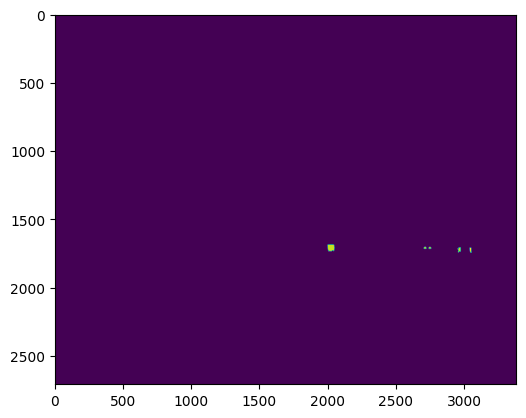

In [7]:
with ZipFile(train_label_path) as myzip:
    with myzip.open('train_label/' + '170908_072637296_Camera_5_instanceIds.png') as myfile:
        image = mpimg.imread(myfile)
        img = imread(myfile)
        print(np.unique(np.array(img), return_counts=1))
        plt.imshow(image)

# create data loader

In [8]:
from torchvision.transforms.functional import pil_to_tensor

In [9]:
def print_simple_data_pipe(date_pipe: torchdata.datapipes.iter.IterDataPipe, f=lambda a: a, n=10) -> None:
  print(type(date_pipe))
  x = 0
  for sample in date_pipe:
    print(f(sample))
    if x == n:
      break
    x +=1


def loadSegmentImage(img_name):
  with ZipFile(train_label_path) as myzip:
    with myzip.open('train_label/' + f'{img_name}_instanceIds.png') as myfile:
        image = imread(myfile).astype(int)
  return torch.from_numpy(image)


def loadSourceImage(img_name):
  with ZipFile(train_color_path) as myzip:
    with myzip.open('train_color/' + f'{img_name}.jpg') as myfile:
        image = Image.open(myfile)
        image = pil_to_tensor(image)
  return image


def reshapeLabeled(img):
  l = [(img == 255).unsqueeze(0).clone()]
  # k = torch.unique(img)
  for i in ids_classes_pairs:
    n = img // 1000 
    t: torch.tensor = n == i
    l.append(t.unsqueeze(0).clone())
  return torch.cat(l, 0)


def loadImagePair(row):
  try:
    return loadSourceImage(row[4]).unsqueeze(0), reshapeLabeled(loadSegmentImage(row[4])).unsqueeze(0)
  except:
    return None, None


In [10]:
bad_ = ['170908_084900808_Camera_6']

In [11]:
dataset_description = pd.read_csv(dataset_description_path)
print(dataset_description.shape)
dataset_description.head()

(42369, 19)


,Unnamed: 0,road,record,camera,name,car_number,car_instances,motorbicycle_number,motorbicycle_instances,bicycle_number,bicycle_instances,truck_number,truck_instances,bus_number,bus_instances,tricycle_number,tricycle_instances,person_number,person_instances
0,0,road01_ins,Record011,Camera 6,170908_061502408_Camera_6,578.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,272.0,1.0,228.0,1.0,0.0,0.0
1,1,road01_ins,Record011,Camera 6,170908_061502547_Camera_6,589.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,223.0,1.0,205.0,1.0,0.0,0.0
2,2,road01_ins,Record011,Camera 6,170908_061502686_Camera_6,624.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,247.0,1.0,292.0,1.0,0.0,0.0
3,3,road01_ins,Record011,Camera 6,170908_061502825_Camera_6,535.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,209.0,1.0,246.0,1.0,0.0,0.0
4,4,road01_ins,Record011,Camera 6,170908_061502964_Camera_6,578.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,271.0,1.0,285.0,1.0,0.0,0.0


In [12]:
import sys

In [13]:
output_res = torchdata.datapipes.iter.IterableWrapper([dataset_description_path])
output_res_pipe = torchdata.datapipes.iter.FileOpener(output_res, mode='r', encoding='utf-8', length=dataset_description.shape[0])
res_pipe = output_res_pipe.parse_csv(skip_lines=1, delimiter=',')
res_pipe = torchdata.datapipes.map.SequenceWrapper(list(res_pipe))
ready = res_pipe.map(loadImagePair)
# ready = ready.map(prepearImage)
train_dataloader = torchdata.datapipes.map.Shuffler(ready).batch(batch_size=1).map(lambda a: a)

In [14]:
print_simple_data_pipe(train_dataloader, f=lambda a: [sys.getsizeof(a[0]), sys.getsizeof(a[1]), sys.getsizeof(a), a[0][0].shape, a[0][1].shape] if a != [(None, None), (None, None), (None, None)] else 'err', n=2)

<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>


IndexError: list index out of range

In [15]:
for test_images in train_dataloader:
    break

In [16]:
input_test_data = torch.cat([i[0] for i in test_images], 0)

# Resnet prep

In [17]:
import torch.nn as nn

In [18]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights


In [19]:
fcn_resnet = fcn_resnet50(weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)
for i in fcn_resnet.parameters():
    i.requires_grad = False
maskrcnn_resnet = maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1)
img_preprocessor = FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1.transforms(resize_size=None)
maskrcnn_resnet.eval()
fcn_resnet.eval()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [20]:
fcn_resnet.classifier[4] = nn.Conv2d(512, len(ids_classes_pairs), kernel_size=(1, 1), stride=(1, 1))
for i in fcn_resnet.classifier.parameters():
    i.requires_grad = True

In [21]:
for i in fcn_resnet.backbone.layer4[2].parameters():
    i.requires_grad = True

In [22]:
input_test_data.long().shape

torch.Size([1, 3, 2710, 3384])

In [23]:
segmented_img = fcn_resnet(img_preprocessor(input_test_data))

In [26]:
segmented_img['out'].shape

torch.Size([1, 36, 2710, 3384])